In [1]:
from Game.BlackJack import BlackJack
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

## 1. Simulation and Labeled Data Generation
> In this part, we generate the labeled data for the training of the model. We will simulate the game process and generate the training data simultaneously. The data will be stored in a csv file for the training of the model.

In [14]:
rounds = 40000
num_decks = 1

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []
dealer_bust = []

first_game = True
prev_round = 0
stack_num_list = []
new_stack = []
card_count_list = []
games_played_with_stack = []

for round_ in trange(rounds):
    games_played = 0
    
    # Make a dict for keeping track of the count for a stack
    
    game = BlackJack()
    
    while len(game.deck) > 20:

        game.start()
        curr_player_results = None
        
        dealer_hand = []
        player_hands = []
        live_total = []
        live_action = []

       
        
        # Record the player's live total after cards are dealt
        live_total.append(game.get_playervalue())
        
        if round_ < rounds / 2:
            hit_stay = "hit"
            action = 1
        else:
            hit_stay = "stay"
            action = 0
        
        game.play(hit_stay, "basic")
        
        dealer_value = game.get_dealervalue()
        player_value = game.get_playervalue()
        if dealer_value > 21:
            dealer_bust.append(1)
            if player_value > 21:
                curr_player_results = 0
            else:
                curr_player_results = 1
        else:
            dealer_bust.append(0)
            if player_value > 21:
                curr_player_results = -1
            elif player_value > dealer_value:
                curr_player_results = 1
            elif player_value == dealer_value:
                curr_player_results = 0
            else:
                curr_player_results = -1

        # Track features
        dealer_card_feature.append(game.dealer_hand[0]['number'])
        player_card_feature.append(game.player_hand.copy())
        player_results.append(curr_player_results)
        # player_live_total.append(live_total)
        player_live_action.append(action)
        
        # Update card count list with most recent game's card count
        if round_ != prev_round:
            new_stack.append(1)
        else:
            new_stack.append(0)
            if first_game == True:
                first_game = False
            else:
                games_played += 1
            
        stack_num_list.append(round_)
        games_played_with_stack.append(games_played)
        card_count_list.append(game.card_count.copy())
        prev_round = round_

        
    game.reset()
        
        
        
model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [game.total_value(i[:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in [card['number'] for card in i]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace
dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    elif i in ['J', 'Q', 'K']:
        dealer_card_num.append(10)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['Y'] = player_results
lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct
card_count_df = pd.concat([pd.DataFrame(new_stack, columns=['new_stack']),
                           pd.DataFrame(games_played_with_stack, columns=['games_played_with_stack']),
                           pd.DataFrame.from_dict(card_count_list),
                           pd.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1)
model_df = pd.concat([model_df, card_count_df], axis=1)

100%|██████████| 40000/40000 [00:02<00:00, 17014.12it/s]


In [15]:
print(len(model_df.columns))
model_df.to_csv("./Data/blackjack_simulation_data.csv", index=False)

21


## 2. Model Evalutation
> In this part, we will test different agents on the environment and compare their performance from different aspects.

### 2.1 Win Rate & Draw Rate
We will test 10000 games for each agent and calculate the win rate and draw rate of each agent.

In [2]:
from Game.BlackJack import BlackJack
from Agent.random.randomagent import RandomAgent
from Agent.nn.nnagent import nnAgent
from Agent.LLM.LLM_Agent import LLMAgent
from Agent.base.baseAgent import BaseAgent
from Agent.qlearning.qLearningAgent import qLearningAgent
from Agent.expectimax.expectimaxAgent import ExpectimaxAgent
from Agent.MDP.MDPagent import MDPAgent
from Agent.bayes.bayesAgent import NaiveBayesAgent

In [4]:
# agent = nnAgent()

agents = [RandomAgent(), BaseAgent(), ExpectimaxAgent(), NaiveBayesAgent(), MDPAgent(), qLearningAgent(), nnAgent()]

d:\SHTECH\G3S1\CS181 Introduction to AI\Project\Final\BLACKJACK\Agent\nn\nnagent.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(m

In [5]:

rounds = 10000
win_rates = {}
draw_rates = {}
for agent in agents:
    game = BlackJack("novel")
    results = {"win": 0, "lose": 0, "draw": 0}
    for i in trange(rounds):
        game.start()
        # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))
        while game.status == "continue":
            action = agent.choose_action(game)
            game.play(action, "basic")
            if action == "stay":
                break
        # print(f"dealer's hand: {game.format_cards(game.dealer_hand)} {game.get_dealervalue()}  player's hand: {game.format_cards(game.player_hand)} {game.get_playervalue()}")
        results[game.game_result()] += 1
        
        if len(game.deck) < 20:
            game.reset()
        
    win_rates[agent.__class__.__name__] = results["win"] / rounds
    draw_rates[agent.__class__.__name__] = results["draw"] / rounds
    
## Draw the bar chart of the win rate, lose rate, and draw rate



100%|██████████| 10000/10000 [00:11<00:00, 840.46it/s]


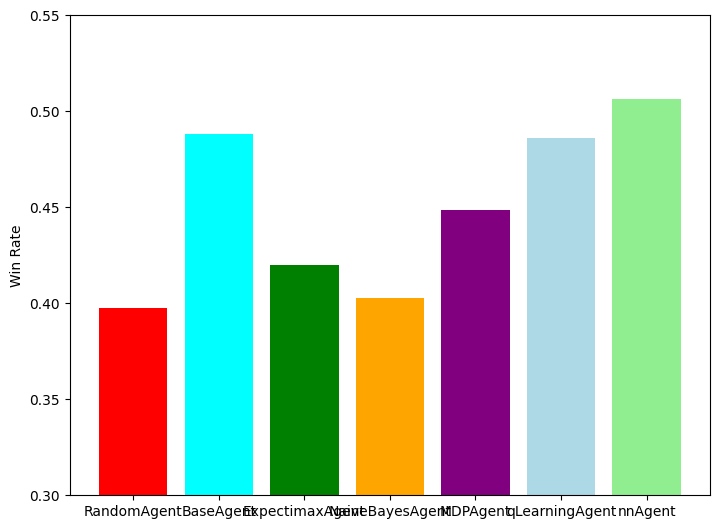

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
colors = ['red', 'cyan', 'green', 'orange', 'purple', "LightBlue", "LightGreen"]
ax.bar(win_rates.keys(), win_rates.values(), color=colors)
ax.set_ylim(0.3, 0.55) 
plt.ylabel('Win Rate')
plt.show()

In [7]:
win_rates

{'RandomAgent': 0.3978,
 'BaseAgent': 0.4882,
 'ExpectimaxAgent': 0.42,
 'NaiveBayesAgent': 0.4025,
 'MDPAgent': 0.4484,
 'qLearningAgent': 0.486,
 'nnAgent': 0.5063}

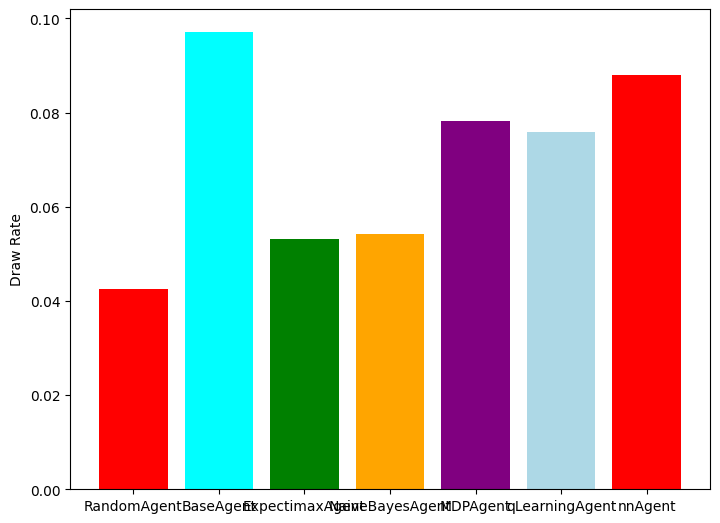

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
colors = ['red', 'cyan', 'green', 'orange', 'purple', "LightBlue"]
ax.bar(draw_rates.keys(), draw_rates.values(), color=colors)
# ax.set_ylim(0.3, 0.55) 
plt.ylabel('Draw Rate')
plt.show()

In [9]:
draw_rates

{'RandomAgent': 0.0426,
 'BaseAgent': 0.0971,
 'ExpectimaxAgent': 0.0531,
 'NaiveBayesAgent': 0.0543,
 'MDPAgent': 0.0783,
 'qLearningAgent': 0.0759,
 'nnAgent': 0.0879}

## 2.2 Real Casino Simulation
In this test, we will simulate the real casino environment and test the performance of each agent. To be specific, we suppose each agent and the dealer have $100000 initially and we will test 10000 games for each agent. Each time each agent will bet 10% of their total money. We will calculate the final money of each agent and compare their performance.

### 2.2.1 Long-term Performance

In [13]:
rounds = 2000
bet_rounds = {}
final_money = {}
money_history = {}
for agent in agents:
    player_money = 10000
    dealer_money = 5000000
    game = BlackJack("novel")
    money_history[agent.__class__.__name__] = []
    for round_ in trange(rounds):
        game.start()
        bet = min(0.1*player_money, 0.1*dealer_money)
        while game.status == "continue":
            action = agent.choose_action(game)
            game.play(action, "basic")
            if action == "stay":
                break
        if game.game_result() == "win":
            player_money += bet
            dealer_money -= bet
        elif game.game_result() == "lose":
            player_money -= bet
            dealer_money += bet
        money_history[agent.__class__.__name__].append(player_money)
        if len(game.deck) < 20:
            game.reset()
        if player_money <= 1e-6 or dealer_money <= 1e-6:
            break
    bet_rounds[agent.__class__.__name__] = round_
    final_money[agent.__class__.__name__] = round(player_money)
    
    


100%|██████████| 2000/2000 [00:02<00:00, 823.45it/s]


In [14]:
bet_rounds, final_money

({'RandomAgent': 1069,
  'BaseAgent': 1999,
  'ExpectimaxAgent': 1353,
  'NaiveBayesAgent': 1596,
  'MDPAgent': 1999,
  'qLearningAgent': 1999,
  'nnAgent': 1999},
 {'RandomAgent': 0,
  'BaseAgent': 1122325,
  'ExpectimaxAgent': 0,
  'NaiveBayesAgent': 0,
  'MDPAgent': 0,
  'qLearningAgent': 5009969,
  'nnAgent': 5009959})

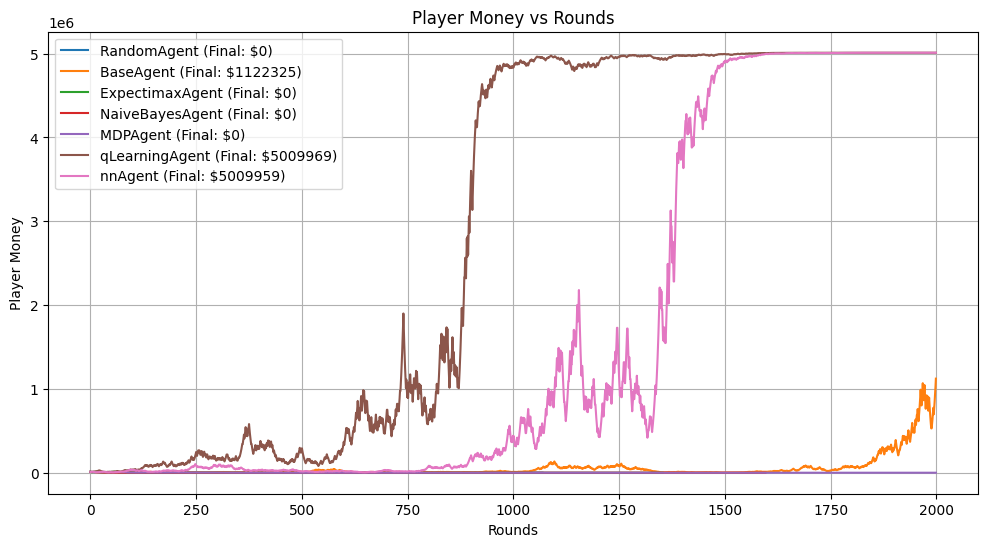

In [15]:
plt.figure(figsize=(12, 6))
for agent_name, history in money_history.items():
    plt.plot(history, label=f"{agent_name} (Final: ${final_money[agent_name]})")

plt.title("Player Money vs Rounds")
plt.xlabel("Rounds")
plt.ylabel("Player Money")
plt.legend()
plt.grid()
plt.show()

### 2.2.2 Short-term Performance
> We will test the performance of each agent in the first 100 games for 100 times and compare their performance for both traditional and novel rules.




In [30]:
""" 
This part is for the our novel(fair) blackjack game(Draw if bust simultaneously)
"""
rounds = 100  
num_tests = 100  
bet_rounds = {}
final_money = {}
average_money_history = {}  

# 遍历每个代理
for agent in agents:
    player_money_init = 10000
    dealer_money_init = 5000000
    money_history = []
    print(f"Testing {agent.__class__.__name__}...")

    for test in trange(num_tests):
        player_money = player_money_init
        dealer_money = dealer_money_init
        game = BlackJack("novel")
        single_run_history = [] 

        for round_ in range(rounds):
            game.start()
            bet = min(0.1 * player_money, 0.1 * dealer_money)

            while game.status == "continue":
                action = agent.choose_action(game)
                game.play(action, "basic")
                if action == "stay":
                    break

            if game.game_result() == "win":
                player_money += bet
                dealer_money -= bet
            elif game.game_result() == "lose":
                player_money -= bet
                dealer_money += bet

            single_run_history.append(player_money)  

            if len(game.deck) < 20:
                game.reset()
            if player_money <= 1e-6 or dealer_money <= 1e-6:
                break

        money_history.append(single_run_history)


    max_length = max(len(history) for history in money_history)
    
    ## Ensure that all histories have the same length
    padded_histories = [history + [history[-1]] * (max_length - len(history)) for history in money_history]
    average_money_history[agent.__class__.__name__] = np.mean(padded_histories, axis=0)

Testing RandomAgent...


100%|██████████| 100/100 [00:00<00:00, 1508.34it/s]


Testing BaseAgent...


100%|██████████| 100/100 [00:00<00:00, 1401.70it/s]


Testing ExpectimaxAgent...


100%|██████████| 100/100 [00:00<00:00, 1071.70it/s]


Testing NaiveBayesAgent...


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


Testing MDPAgent...


100%|██████████| 100/100 [00:00<00:00, 1140.75it/s]


Testing qLearningAgent...


100%|██████████| 100/100 [00:00<00:00, 1080.44it/s]


Testing nnAgent...


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


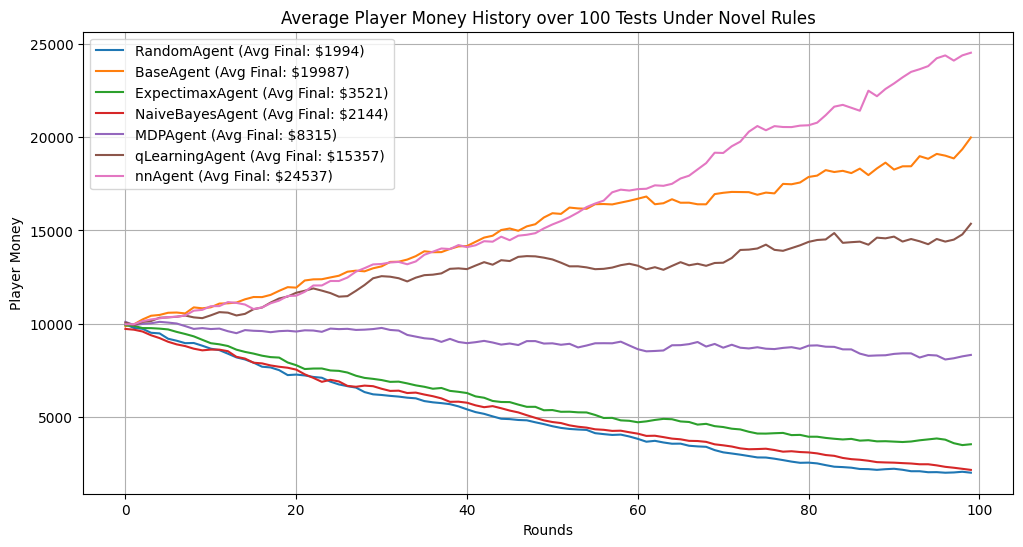

In [32]:
plt.figure(figsize=(12, 6))
for agent_name, avg_history in average_money_history.items():
    plt.plot(avg_history, label=f"{agent_name} (Avg Final: ${round(avg_history[-1])})")

plt.title("Average Player Money History over 100 Tests Under Novel Rules")
plt.xlabel("Rounds")
plt.ylabel("Player Money")
plt.legend()
plt.grid()
plt.show()

In [34]:
""" 
This part is for the traditional blackjack game(Lose if bust simultaneously)
"""
rounds = 100  
num_tests = 100  
bet_rounds = {}
final_money = {}
average_money_history = {}  

for agent in agents:
    player_money_init = 10000
    dealer_money_init = 5000000
    money_history = []
    print(f"Testing {agent.__class__.__name__}...")

    for test in trange(num_tests):
        player_money = player_money_init
        dealer_money = dealer_money_init
        game = BlackJack()
        single_run_history = [] 

        for round_ in range(rounds):
            game.start()
            bet = min(0.1 * player_money, 0.1 * dealer_money)

            while game.status == "continue":
                action = agent.choose_action(game)
                game.play(action, "basic")
                if action == "stay":
                    break

            if game.game_result() == "win":
                player_money += bet
                dealer_money -= bet
            elif game.game_result() == "lose":
                player_money -= bet
                dealer_money += bet

            single_run_history.append(player_money)  

            if len(game.deck) < 20:
                game.reset()
            if player_money <= 1e-6 or dealer_money <= 1e-6:
                break

        money_history.append(single_run_history)


    max_length = max(len(history) for history in money_history)
    
    ## Ensure that all histories have the same length
    padded_histories = [history + [history[-1]] * (max_length - len(history)) for history in money_history]
    average_money_history[agent.__class__.__name__] = np.mean(padded_histories, axis=0)

Testing RandomAgent...


100%|██████████| 100/100 [00:00<00:00, 1483.47it/s]


Testing BaseAgent...


100%|██████████| 100/100 [00:00<00:00, 1399.24it/s]


Testing ExpectimaxAgent...


100%|██████████| 100/100 [00:00<00:00, 1065.84it/s]


Testing NaiveBayesAgent...


100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


Testing MDPAgent...


100%|██████████| 100/100 [00:00<00:00, 1226.47it/s]


Testing qLearningAgent...


100%|██████████| 100/100 [00:00<00:00, 1100.92it/s]


Testing nnAgent...


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


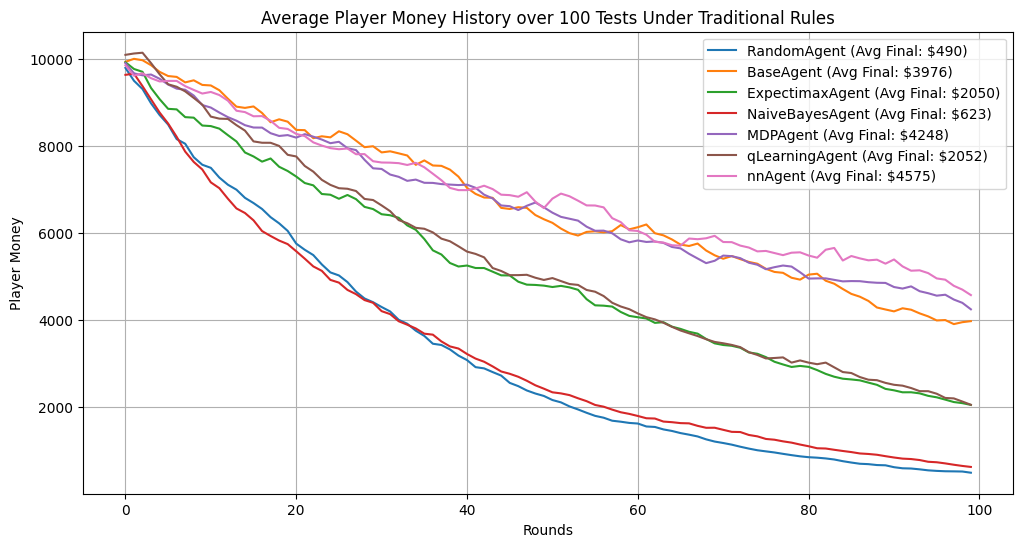

In [35]:
plt.figure(figsize=(12, 6))
for agent_name, avg_history in average_money_history.items():
    plt.plot(avg_history, label=f"{agent_name} (Avg Final: ${round(avg_history[-1])})")

plt.title("Average Player Money History over 100 Tests Under Traditional Rules")
plt.xlabel("Rounds")
plt.ylabel("Player Money")
plt.legend()
plt.grid()
plt.show()